In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cv
import time
import gurobipy as gp
from gurobipy import GRB
import scipy

In [2]:
rng = np.random.default_rng(5764)

# Cross Model Interaction

So far we have simulated data from a model of two interacting genes, where each produces transcripts according to a model such as birth-death or telegraph and the transcripts interact via a regulatory reaction, and then used the same model structure to test whether the data indicates the presence of interaction.

i.e. simulate data from a birth-death interaction model, then optimize over the same model to test if there is interaction

However, when working with real data we do not know 'which model the data follows' as it is not simulated from one: in reality the models are only approximations of the process of gene expression / transcription. So given data should we optimize using a birth-death model structure or a telegraph model structure?

To investigate we will simulate data from both models and use both model structures to test for interaction, comparing the results to see if any issues arise / what is the best choice.

#### Expectations

The telegraph is a more general model (the special case when the gene is always on, $k_{off} = 0, k_{on} > 0$, gives the birth-death model) so data simulated under it may not fit the more specific birth-death model. When assuming $k_{reg} = 0$ this could lead to an infeasible result and so a false conclusion of interaction, even though the infeasiblity was not due to this assumption (perhaps testing for infeasibility without fixing $k_{reg} = 0$ could help distinguish these cases).

Data simulated under a birth-death model will fit a telegraph model as it is more general, but this generality also means the optimization is harder and so results may be significanty worse than using the simpler birth-death model.

# Code: simulation, bootstrap, optimization

In [3]:
def simulation_BD(params, n, tmax, ts, plot=False, initial_state=(0, 0)):
    '''
    Simulate a sample path of the birth death regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2 = path[-1][0], path[-1][1]

        # transition rates
        q_tx_1 = params['k_tx_1']
        q_tx_2 = params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_tx_1 + q_tx_2 + q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5]
        prob = [
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1 + 1, x2))
            case 2:
                path.append((x1, x2 + 1))
            case 3:
                path.append((x1 - 1, x2))
            case 4:
                path.append((x1, x2 - 1))
            case 5:
                path.append((x1 - 1, x2 - 1))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)
    samples = [(int(x1_samples[i]), int(x2_samples[i])) for i in range(n)]

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("# molcules")
        plt.legend()
        plt.show()

    return samples

In [4]:
def simulation_TE(params, n, tmax, ts, plot=False, initial_state=(0, 0, 1, 1)):
    '''
    Simulate a sample path of the telegraph-regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2, g1, g2 = path[-1][0], path[-1][1], path[-1][2], path[-1][3]

        # transition rates
        q_on_1 = (1 - g1) * params['k_on_1']
        q_on_2 = (1 - g2) * params['k_on_2']
        q_off_1 = g1 * params['k_off_1']
        q_off_2 = g2 * params['k_off_2']
        q_tx_1 = g1 * params['k_tx_1']
        q_tx_2 = g2 * params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_on_1 + q_on_2 + q_off_1 + q_off_2 + q_tx_1 + q_tx_2 + \
            q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9]
        prob = [
            q_on_1 / q_hold,
            q_on_2 / q_hold,
            q_off_1 / q_hold,
            q_off_2 / q_hold,
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1, x2, g1 + 1, g2))
            case 2:
                path.append((x1, x2, g1, g2 + 1))
            case 3:
                path.append((x1, x2, g1 - 1, g2))
            case 4:
                path.append((x1, x2, g1, g2 - 1))
            case 5:
                path.append((x1 + 1, x2, g1, g2))
            case 6:
                path.append((x1, x2 + 1, g1, g2))
            case 7:
                path.append((x1 - 1, x2, g1, g2))
            case 8:
                path.append((x1, x2 - 1, g1, g2))
            case 9:
                path.append((x1 - 1, x2 - 1, g1, g2))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)
    samples = [(int(x1_samples[i]), int(x2_samples[i])) for i in range(n)]

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("# molcules")
        plt.legend()
        plt.show()

    return samples

In [182]:
def bootstrap(params, n, B, mtype="BD", alpha=0.05, tmax=100, ts=10, thresh=1, plot=False, printing=False, initial_state=(0, 0, 1, 1)):
    '''
    Compute bootstrap confidence intervals on stationary distribution by 
    simulating sample path and computing empirical distribution over 
    several bootstrap samples

    params: dict of reaction rate constants
    n: number of samples from stationary distribution
    B: number of bootstrap resamples
    type: type of model data is simulated from, "BD" birth-death or "TE" telegraph OR a provided sample
    alpha: confidence level, 0.05 corresponds to 95% CI's
    tmax: burn-in time for sampling
    ts: time between samples
    thresh: minimum occurnces of a state in the original sample to use the CI
        otherwise replaced by [0, 1] bounds
    plot: toggle plotting CI's
    printing: toggle printing CI's
    initial_state: starting point of sampling
    '''

    # simulate n samples from stationary distribution
    if mtype == "BD":
        samples = simulation_BD(params, n, tmax, ts, plot=False, initial_state=initial_state[0:2])
    elif mtype == "TE":
        samples = simulation_TE(params, n, tmax, ts, plot=False, initial_state=initial_state)
    # OR use provided sample
    else:
        samples = mtype

    # compute maximum x1 and x2 values
    M = np.max([sample[0] for sample in samples])
    N = np.max([sample[1] for sample in samples])

    # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
    integer_samples = [sample[1] + (N + 1)*sample[0] for sample in samples]

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # B bootstrap samples as B x n array
    bootstrap = rng.choice(integer_samples, size=(B, n))

    # offset row i by (D + 1)i
    bootstrap_offset = bootstrap + np.arange(B)[:, None]*(D + 1)

    # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
    counts = np.bincount(bootstrap_offset.ravel(), minlength=B*(D + 1)).reshape(-1, M + 1, N + 1)

    # counts to probability
    counts = counts / n

    # sum over columns / rows to give counts of each x1 / x2 state
    x1_counts = counts.sum(axis=2)
    x2_counts = counts.sum(axis=1)

    # compute 2.5% and 97.5% quantiles for each p(x1, x2), p(x1) and p(x2)
    bounds = np.quantile(counts, [alpha / 2, 1 - (alpha / 2)], axis=0)
    x1_bounds = np.quantile(x1_counts, [alpha / 2, 1 - (alpha / 2)], axis=0)
    x2_bounds = np.quantile(x2_counts, [alpha / 2, 1 - (alpha / 2)], axis=0)

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_samples, minlength=D + 1).reshape(M + 1, N + 1)

    # sum over columns / rows to give counts per x1 / x2 state
    x1_sample_counts = sample_counts.sum(axis=1)
    x2_sample_counts = sample_counts.sum(axis=0)

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            if sample_counts[x1, x2] < thresh:
                bounds[:, x1, x2] = [0.0, 1.0]

    for x1 in range(M + 1):
        if x1_sample_counts[x1] < thresh:
            x1_bounds[:, x1] = [0.0, 1.0]

    for x2 in range(N + 1):
        if x2_sample_counts[x2] < thresh:
            x2_bounds[:, x2] = [0.0, 1.0]

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                axs[x1, x2].hist(counts[:, x1, x2])
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color="red")
                axs[x1, x2].axvline(bounds[1, x1, x2], color="red")

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M + 1, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M + 1):
            axs[x1].hist(x1_counts[:, x1])
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color="red")
            axs[x1].axvline(x1_bounds[1, x1], color="red")

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N + 1, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N + 1):
            axs[x2].hist(x2_counts[:, x2])
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color="red")
            axs[x2].axvline(x2_bounds[1, x2], color="red")

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    return {'joint': bounds, 'x1': x1_bounds, 'x2': x2_bounds}

In [6]:
def optimization_BD(params, bounds, N=None, M=None, K=10, silent=True, frechet=True, print_solution=True, test_feasible=False, param_bounds=None):
    '''
    Non-linear optimization to produce bounds on parameters of interest

    params: dictionary of reaction rate constants
            fixed value, "v" for variable, "vo" for variable to optimize
    bounds: 2 x M x N array of confidence interval bounds on stat. dist. of system
    silent: toggle printing of optimization status
    '''

    # create model
    md = gp.Model('birth-death-regulation')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set 5 minute time limit
    md.Params.TimeLimit = 300

    # size
    if not M:
        M = bounds.shape[1]
    if not N:
        N = bounds.shape[2]

    # variables

    # stationary distribution
    p = md.addMVar(shape=(M, N), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # set fixed values
    for name, value in params.items():
        if value == "v" or value == "vo":
            pass
        else:
            md.addConstr(rates[name] == value)

    # add any bounds given
    try:
        for name, value in param_bounds.items():
            md.addConstr(rates[name] <= value[1])
            md.addConstr(rates[name] >= value[0])
    except AttributeError:
        pass

    # stationary distribution bounds
    for x1 in range(M):
        for x2 in range(N):
            md.addConstr(p[x1, x2] >= bounds['joint'][0, x1, x2], name=f"lb {x1}, {x2}")
            md.addConstr(p[x1, x2] <= bounds['joint'][1, x1, x2], name=f"ub {x1}, {x2}")

            # additional frechet bounds
            if frechet:
                md.addConstr(p[x1, x2] >= bounds['x1'][0, x1] + bounds['x2'][0, x2] - 1, name=f"Frechet lb {x1}, {x2}")
                md.addConstr(p[x1, x2] <= bounds['x1'][1, x1], name=f"Frechet ub x1 {x1}, {x2}")
                md.addConstr(p[x1, x2] <= bounds['x2'][1, x2], name=f"Frechet ub x2 {x2}, {x2}")

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # stationary Qp=0 equations for all relevant variables
    for x1 in range(M - 1):
        for x2 in range(N - 1):
            if x1 == 0:
                x1_zero = 0
            else:
                x1_zero = 1
            if x2 == 0:
                x2_zero = 0
            else:
                x2_zero = 1

            md.addConstr(
                # remove terms when x1 or x2 = 0 since not in equation
                # so multiply by toggle
                rates['k_tx_1'] * x1_zero * p[x1 - 1, x2] + \
                rates['k_tx_2'] * x2_zero * p[x1, x2 - 1] + \
                rates['k_deg_1'] * (x1 + 1) * p[x1 + 1, x2] + \
                rates['k_deg_2'] * (x2 + 1) * p[x1, x2 + 1] + \
                rates['k_reg'] * (x1 + 1) * (x2 + 1) * p[x1 + 1, x2 + 1] - \
                (rates['k_tx_1'] + rates['k_tx_2'] + \
                 rates['k_deg_1'] * x1 + rates['k_deg_2'] * x2 + \
                 rates['k_reg'] * x1 * x2) * p[x1, x2] == 0,
                name=f"Equation {x1}, {x2}"
                )

    # solution dict
    solution = {}

    # optimize
    for name, value in params.items():

        # variable
        if value == "vo":

            # minimize
            md.setObjective(rates[name], GRB.MINIMIZE)
            try:
                md.optimize()
                min_val = md.ObjVal
            except:
                min_val = None

            # maximize
            md.setObjective(rates[name], GRB.MAXIMIZE)
            try:
                md.optimize()
                max_val = md.ObjVal
            except:
                max_val = None

            # store
            solution[name] = [min_val, max_val]
    
        # constant
        else:
            solution[name] = value

    if test_feasible:
        # if testing feasibility simply optimize 0 to check
        md.setObjective(0, GRB.MINIMIZE)

        # set parameter (prevents 'infeasible or unbounded' ambiguity)
        md.Params.DualReductions = 0
        try:
            md.optimize()
            status_code = md.status
        except:
            status_code = md.status

        # decode status
        status_codes = {1: 'LOADED',
                        2: 'OPTIMAL',
                        3: 'INFEASIBLE',
                        4: 'INF_OR_UNBD',
                        5: 'UNBOUNDED',
                        6: 'CUTOFF',
                        7: 'ITERATION_LIMIT',
                        8: 'NODE_LIMIT',
                        9: 'TIME_LIMIT',
                        10: 'SOLUTION_LIMIT',
                        11: 'INTERRUPTED',
                        12: 'NUMERIC',
                        13: 'SUBOPTIMAL',
                        14: 'INPROGRESS',
                        15: 'USER_OBJ_LIMIT'}

        # store result
        solution['feasible'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == 'feasible':
                print(f"Model is {val}")
            elif type(val) == list:
                print(f"{key} in ({val[0]}, {val[1]})")
            elif val == "v":
                print(f"{key} variable, not optimized")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

In [7]:
def optimization_TE(params, bounds, N=None, M=None, K=10, silent=True, print_solution=True, test_feasible=False, param_bounds=None,
                 time_limit=300, MIPGap=0.0004, MIPFocus=0, Heuristics=0.05, presolve=-1, norelheur_time=0, maxim=True):
    '''
    Non-linear optimization to produce bounds on parameters of interest

    params: variable or fixed reaction rate constants
    bounds: 2 x M x N array of confidence interval bounds on stat. dist. of system
    silent: toggle printing of optimization status
    '''

    # create model
    md = gp.Model('telegraph-regulation')

    # settings
    if silent:
        md.Params.LogToConsole = 0

    # 5 minute time limit
    md.Params.TimeLimit = time_limit

    # optimization settings
    md.Params.MIPGap = MIPGap
    md.Params.Heuristics = Heuristics
    md.Params.Presolve = presolve
    md.Params.NoRelHeurTime = norelheur_time
    md.Params.MIPFocus = MIPFocus

    # size
    if not M:
        M = bounds.shape[1]
    if not N:
        N = bounds.shape[2]

    # variables

    # stationary distribution
    p = md.addMVar(shape=(M, N, 2, 2), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    rate_names = ['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # set fixed values
    for name, value in params.items():
        if value == "v" or value == "vo":
            pass
        else:
            md.addConstr(rates[name] == value)

    # add any bounds given
    try:
        for name, value in param_bounds.items():
            md.addConstr(rates[name] <= value[1])
            md.addConstr(rates[name] >= value[0])
    except AttributeError:
        pass

    # (marginal) stationary distribution bounds
    for x1 in range(M):
        for x2 in range(N):
            md.addConstr(bounds['joint'][0, x1, x2] <= p[x1, x2, 0, 0] + p[x1, x2, 1, 0] + p[x1, x2, 0, 1] + p[x1, x2, 1, 1], name=f"Marginal lb {x1}, {x2}")
            md.addConstr(bounds['joint'][1, x1, x2] >= p[x1, x2, 0, 0] + p[x1, x2, 1, 0] + p[x1, x2, 0, 1] + p[x1, x2, 1, 1], name=f"Marginal ub {x1}, {x2}")

    # additional frechet bounds
    for x1 in range(M):
        for x2 in range(N):
            for g1 in [0, 1]:
                for g2 in [0, 1]:
                    # expressions for p(g1) and p(g2)
                    
                    # add new variables
                    p_g1 = md.addVar(vtype=GRB.CONTINUOUS, name='p_g1')
                    p_g2 = md.addVar(vtype=GRB.CONTINUOUS, name='p_g2')

                    # set equal to values
                    if g1 == 1:
                        md.addConstr(p_g1 * (rates['k_on_1'] + rates['k_off_1']) == rates['k_on_1'])
                    else:
                        md.addConstr(p_g1 * (rates['k_on_1'] + rates['k_off_1']) == rates['k_off_1'])
                    if g2 == 1:
                        md.addConstr(p_g2 * (rates['k_on_2'] + rates['k_off_2']) == rates['k_on_2'])
                    else:
                        md.addConstr(p_g2 * (rates['k_on_2'] + rates['k_off_2']) == rates['k_off_2'])

                    # use in bounds
                    md.addConstr(p[x1, x2, g1, g2] >= bounds['x1'][0, x1] + bounds['x2'][0, x2] + p_g1 + p_g2 - 3, name="Frechet all lb")
                    md.addConstr(p[x1, x2, g1, g2] >= bounds['joint'][0, x1, x2] + p_g1 + p_g2 - 2, name="Frechet joint lb")
                    md.addConstr(p[x1, x2, g1, g2] <= bounds['joint'][1, x1, x2])
                    md.addConstr(p[x1, x2, g1, g2] <= bounds['x1'][1, x1])
                    md.addConstr(p[x1, x2, g1, g2] <= bounds['x2'][1, x2])
                    md.addConstr(p[x1, x2, g1, g2] <= p_g1)
                    md.addConstr(p[x1, x2, g1, g2] <= p_g2)

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # stationary Qp=0 equations for all relevant variables
    for x1 in range(M - 1):
        for x2 in range(N - 1):
            for g1 in [0, 1]:
                for g2 in [0, 1]:
                    if x1 == 0:
                        x1_zero = 0
                    else:
                        x1_zero = 1
                    if x2 == 0:
                        x2_zero = 0
                    else:
                        x2_zero = 1

                    md.addConstr( 
                        rates['k_on_1'] * g1 * p[x1, x2, 0, g2] + \
                        rates['k_on_2'] * g2 * p[x1, x2, g1, 0] + \
                        rates['k_off_1'] * (1 - g1) * p[x1, x2, 1, g2] + \
                        rates['k_off_2'] * (1 - g2) * p[x1, x2, g1, 1] + \
                        # need to remove this when x1 or x2 = 0, since not in equation (index = -1 crrently taking end of array)
                        # so multiply by toggle
                        rates['k_tx_1'] * g1 * x1_zero * p[x1 - 1, x2, g1, g2] + \
                        rates['k_tx_2'] * g2 * x2_zero * p[x1, x2 - 1, g1, g2] + \
                        rates['k_deg_1'] * (x1 + 1) * p[x1 + 1, x2, g1, g2] + \
                        rates['k_deg_2'] * (x2 + 1) * p[x1, x2 + 1, g1, g2] + \
                        rates['k_reg'] * (x1 + 1) * (x2 + 1) * p[x1 + 1, x2 + 1, g1, g2] - \
                        (rates['k_on_1'] * (1 - g1) + rates['k_on_2'] * (1 - g2) + \
                         rates['k_off_1'] * g1 + rates['k_off_2'] * g2 + \
                         rates['k_tx_1'] * g1 + rates['k_tx_2'] * g2 + \
                         rates['k_deg_1'] * x1 + rates['k_deg_2'] * x2 + \
                         rates['k_reg'] * x1 * x2) * p[x1, x2, g1, g2] == 0,
                        name=f"Equation {x1}, {x2}, {g1}, {g2}"
                    )

    # status of optimization
    status_codes = {1: 'LOADED',
                    2: 'OPTIMAL',
                    3: 'INFEASIBLE',
                    4: 'INF_OR_UNBD',
                    5: 'UNBOUNDED',
                    6: 'CUTOFF',
                    7: 'ITERATION_LIMIT',
                    8: 'NODE_LIMIT',
                    9: 'TIME_LIMIT',
                    10: 'SOLUTION_LIMIT',
                    11: 'INTERRUPTED',
                    12: 'NUMERIC',
                    13: 'SUBOPTIMAL',
                    14: 'INPROGRESS',
                    15: 'USER_OBJ_LIMIT'}

    # solution dict
    solution = {}

    # optimize
    for name, value in params.items():

        # variable
        if value == "vo":

            # minimize
            md.setObjective(rates[name], GRB.MINIMIZE)
            try:
                md.optimize()
                min_val = md.ObjVal
            except:
                min_val = None
                
            # decode status: store result
            status_min = status_codes[md.status]

            # maximize (if needed)
            if maxim:
                md.setObjective(rates[name], GRB.MAXIMIZE)
                try:
                    md.optimize()
                    max_val = md.ObjVal
                except:
                    max_val = None

                # decode status: store result
                status_max = status_codes[md.status]

            # store
            if maxim:
                solution[name] = [min_val, max_val, status_min, status_max]
            else:
                solution[name] = [min_val, status_min]
    
        # constant
        else:
            solution[name] = value

    md.Params.DualReductions = 0

    if test_feasible:
        # if testing feasibility simply optimize 0 to check
        md.setObjective(0, GRB.MINIMIZE)

        # set parameter (prevents 'infeasible or unbounded' ambiguity)
        md.Params.DualReductions = 0

        # set solution limit (stop after finding 1 feasible solution)
        md.Params.SolutionLimit = 1

        try:
            md.optimize()
            status_code = md.status
        except:
            status_code = md.status

        # decode status: store result
        solution['feasible'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == 'feasible':
                print(f"Model is {val}")
            elif type(val) == list:
                if maxim:
                    print(f"{key} in ({val[0]}, {val[1]}), status {val[2]} {val[3]}")
                else:
                    print(f"{key} lower bound {val[0]}, status {val[1]}")
            elif val == "v":
                print(f"{key} variable, not optimized")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

# Investigation

Simulate data from both models for a range of interaction levels and parameter values, then optimize using each model (and methods 1 and 2 for BD optimization)

In [8]:
# simulation parameters for interacting birth-death (BD) model
params_simul_BD_high = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 10
}

params_simul_BD_medium = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

params_simul_BD_low = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0.1
}

params_simul_BD_no = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# simulation parameters for interacting telegraph (TE) model
params_simul_TE_high = {
    'k_on_1': 0.9,
    'k_on_2': 0.9,
    'k_off_1': 0.1,
    'k_off_2': 0.1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 10
}

params_simul_TE_medium = {
    'k_on_1': 0.9,
    'k_on_2': 0.9,
    'k_off_1': 0.1,
    'k_off_2': 0.1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

params_simul_TE_low = {
    'k_on_1': 0.9,
    'k_on_2': 0.9,
    'k_off_1': 0.1,
    'k_off_2': 0.1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0.1
}

params_simul_TE_no = {
    'k_on_1': 0.9,
    'k_on_2': 0.9,
    'k_off_1': 0.1,
    'k_off_2': 0.1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

In [21]:
# optimization parameters for BD method 1 and method 2
params_optim_BD_m1 = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "vo"
}

params_optim_BD_m2 = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# optimization parameters for TE method 1 and 2
params_optim_TE_m1 = {
    'k_on_1': "v", 
    'k_on_2': "v",
    'k_off_1': "v",
    'k_off_2': "v",
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "vo"
}

params_optim_TE_m2 = {
    'k_on_1': "v", 
    'k_on_2': "v",
    'k_off_1': "v",
    'k_off_2': "v",
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

In [10]:
# simulate and compute CI bounds for each parameter set
bounds_BD_high = bootstrap(params_simul_BD_high, 5000, 5000, type="BD", thresh=10, plot=False)
print(f"BD high: {bounds_BD_high['joint'].shape}")

bounds_BD_medium = bootstrap(params_simul_BD_medium, 5000, 5000, type="BD", thresh=10, plot=False)
print(f"BD medium: {bounds_BD_medium['joint'].shape}")

bounds_BD_low = bootstrap(params_simul_BD_low, 5000, 5000, type="BD", thresh=10, plot=False)
print(f"BD low: {bounds_BD_low['joint'].shape}")

bounds_BD_no = bootstrap(params_simul_BD_no, 5000, 5000, type="BD", thresh=10, plot=False)
print(f"BD no: {bounds_BD_no['joint'].shape}")

bounds_TE_high = bootstrap(params_simul_TE_high, 5000, 5000, type="TE", thresh=10, plot=False)
print(f"TE high: {bounds_TE_high['joint'].shape}")

bounds_TE_medium = bootstrap(params_simul_TE_medium, 5000, 5000, type="TE", thresh=10, plot=False)
print(f"TE medium: {bounds_TE_medium['joint'].shape}")

bounds_TE_low = bootstrap(params_simul_TE_low, 5000, 5000, type="TE", thresh=10, plot=False)
print(f"TE low: {bounds_TE_low['joint'].shape}")

bounds_TE_no = bootstrap(params_simul_TE_no, 5000, 5000, type="TE", thresh=10, plot=False)
print(f"TE no: {bounds_TE_no['joint'].shape}")

BD high: (2, 7, 6)
BD medium: (2, 6, 6)
BD low: (2, 9, 8)
BD no: (2, 7, 6)
TE high: (2, 6, 7)
TE medium: (2, 6, 9)
TE low: (2, 8, 7)
TE no: (2, 8, 7)


In [12]:
# collect bounds
bound_list = [
    bounds_BD_high,
    bounds_BD_medium,
    bounds_BD_low,
    bounds_BD_no,
    bounds_TE_high,
    bounds_TE_medium,
    bounds_TE_low,
    bounds_TE_no
]

# list of names
names = [
    'BD_high',
    'BD_medium',
    'BD_low',
    'BD_no',
    'TE_high',
    'TE_medium',
    'TE_low',
    'TE_no'
]

In [17]:
# optimize all data using BD method 1
BD_m1 = {}

for i, bound in enumerate(bound_list):

    # heuristic: use 1 less than available CI bounds for each transcript
    M = bound['joint'].shape[1] - 1
    N = bound['joint'].shape[2] - 1

    # optimize
    print(f"BD m1 for {names[i]}: \n")
    solution = optimization_BD(params_optim_BD_m1, bound, M=M, N=N, K=20, silent=True)
    print("\n")

    # store solutions
    BD_m1[names[i]] = solution

BD m1 for BD_high: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (5.7865410088694995, 20.0)


BD m1 for BD_medium: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (0.19977645713985792, 17.11908812304206)


BD m1 for BD_low: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (0.0, 2.724065868251729)


BD m1 for BD_no: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (0.0, 3.4114643937352684)


BD m1 for TE_high: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (3.4052263755359755, 20.0)


BD m1 for TE_medium: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (0.3922745321745752, 13.184

In [20]:
# optimize all data using BD method 2
BD_m2 = {}

for i, bound in enumerate(bound_list):

    # heuristic: use 1 less than available CI bounds for each transcript
    M = bound['joint'].shape[1] - 1
    N = bound['joint'].shape[2] - 1

    # optimize
    print(f"BD m2 for {names[i]}: \n")
    solution = optimization_BD(params_optim_BD_m2, bound, M=M, N=N, K=20, silent=True, test_feasible=True)
    print("\n")

    # store solutions
    BD_m2[names[i]] = solution

BD m2 for BD_high: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


BD m2 for BD_medium: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


BD m2 for BD_low: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is OPTIMAL


BD m2 for BD_no: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is OPTIMAL


BD m2 for TE_high: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


BD m2 for TE_medium: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


BD m2 for TE_low: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


BD m2 for TE_no: 

k_tx_1 variabl

In [23]:
# optimize all data using TE method 1
TE_m1 = {}

for i, bound in enumerate(bound_list):

    # heuristic: use 1 less than available CI bounds for each transcript
    M = bound['joint'].shape[1] - 1
    N = bound['joint'].shape[2] - 1

    # optimize
    print(f"TE m1 for {names[i]}: \n")
    solution = optimization_TE(params_optim_TE_m1, bound, M=M, N=N, K=20, silent=False, test_feasible=False,
                             MIPGap=0.05, Heuristics=1.0, time_limit=300, presolve=2, maxim=True)
    print("\n")

    # store solutions
    TE_m1[names[i]] = solution

TE m1 for BD_high: 

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.05
Set parameter Heuristics to value 1
Set parameter Presolve to value 2
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 902 rows, 369 columns and 1921 nonzeros
Model fingerprint: 0x737716b7
Model has 320 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 2e+01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [2e-03, 3e+00]
Presolve removed 529 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 517 rows and 1 columns
Presolve time: 0.00s
Presolved: 4225 rows, 1248 columns, 9690 nonzeros
Presolved model has 880 

In [91]:
# optimize all data using TE method 2
TE_m2 = {}

for i, bound in enumerate(bound_list):

    # heuristic: use 1 less than available CI bounds for each transcript
    M = bound['joint'].shape[1] - 1
    N = bound['joint'].shape[2] - 1

    # optimize
    print(f"TE m2 for {names[i]}: \n")
    solution = optimization_TE(params_optim_TE_m2, bound, M=M, N=N, K=20, silent=False, test_feasible=True,
                             MIPGap=0.05, Heuristics=1.0, time_limit=300, presolve=2, maxim=False)
    print("\n")

    # store solutions
    TE_m2[names[i]] = solution

TE m2 for BD_high: 

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.05
Set parameter Heuristics to value 1
Set parameter Presolve to value 2
Set parameter DualReductions to value 0
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 904 rows, 369 columns and 1923 nonzeros
Model fingerprint: 0x0444757d
Model has 320 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 2e+01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [2e-03, 3e+00]
Presolve removed 531 rows and 3 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 519 rows and 3 columns
Presolve time: 0

## Plotted results

In [89]:
# remove model from results (not json serializable)
for dic in [BD_m1, BD_m2, TE_m1, TE_m2]:
    for key in dic.keys():
        dic[key]['model'] = None

In [95]:
# store
import json
#json.dump( BD_m1, open( "BD_m1.json", 'w' ) )
#json.dump( BD_m2, open( "BD_m2.json", 'w' ) )
#json.dump( TE_m1, open( "TE_m1.json", 'w' ) )
# json.dump( TE_m2, open( "TE_m2.json", 'w' ) )

In [ ]:
# load
# json.load( open( "file_name.json" ) )

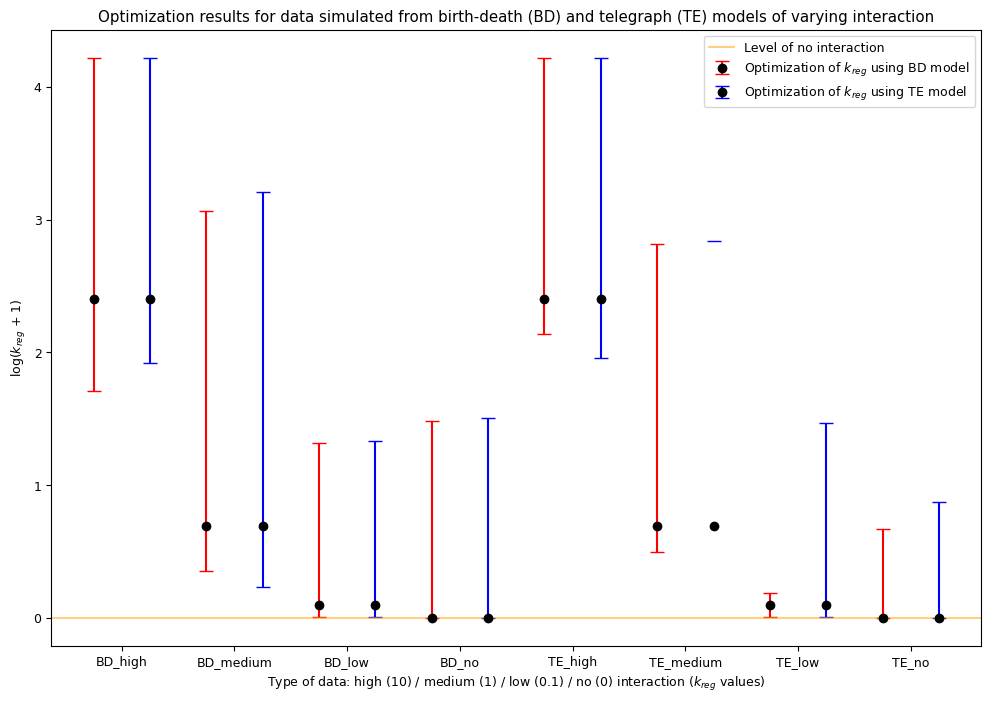

In [84]:
c = 1

def tf(x):
    return np.log(x + c)

ys = np.array([10, 1, 0.1, 0, 10, 1, 0.1, 0])
ys = tf(ys)

plt.figure(figsize=(12, 8))
plt.xticks(np.arange(8), names)

BD_m1_xs = np.arange(8) - 0.25

BD_m1_lbs = []
BD_m1_ubs = []

for i, (key, val) in enumerate(BD_m1.items()):
    dl = abs(tf(val['k_reg'][0]) - tf(ys[i]))
    du = abs(tf(val['k_reg'][1]) - tf(ys[i]))
    BD_m1_lbs.append(dl)
    BD_m1_ubs.append(du)

BD_m1_ybs = [BD_m1_lbs, BD_m1_ubs]
plt.errorbar(BD_m1_xs, ys, yerr=BD_m1_ybs, fmt='o', color='black', ecolor='red', capsize=5.0, label="Optimization of $k_{reg}$ using BD model")

TE_m1_xs = np.arange(8) + 0.25

TE_m1_lbs = []
TE_m1_ubs = []

for i, (key, val) in enumerate(TE_m1.items()):
    dl = abs(tf(val['k_reg'][0]) - tf(ys[i]))
    du = abs(tf(val['k_reg'][1]) - tf(ys[i]))
    TE_m1_lbs.append(dl)
    TE_m1_ubs.append(du)

TE_m1_ybs = [TE_m1_lbs, TE_m1_ubs]
plt.errorbar(TE_m1_xs, ys, yerr=TE_m1_ybs, fmt='o', color='black', ecolor='blue', capsize=5.0, label="Optimization of $k_{reg}$ using TE model")

plt.axhline(tf(0), color="orange", alpha=0.5, label="Level of no interaction")

plt.ylabel("log($k_{reg}$ + " + f"{c}" + ")")
plt.title("Optimization results for data simulated from birth-death (BD) and telegraph (TE) models of varying interaction")
plt.xlabel("Type of data: high (10) / medium (1) / low (0.1) / no (0) interaction ($k_{reg}$ values)")
plt.legend()
plt.show()

For this poisson-like data (TE data has gene mostly on) both model structures for optimization produce good results, detecting high, medium and occassionaly low interaction, with no false positives when there is none present.

The birth-death optimization is significantly faster, taking around 1 second for each sample, and is able to prove optimality of the bounds produced. In contrast, the telegraph optimization is terminated early by a time limit of 5 minutes and does not prove optimiality (in fact most solutions are found in the initial heuristic search phase and are only slightly improved via exploration of the branch-and-bound tree)

## Alternate parameters

Now test on different simulation parameters, with non-poisson like TE data (genes off 50% of the time) and BD data with higher transcription

In [93]:
# simulation parameters for interacting birth-death (BD) model
params_simul_BD_high = {
    'k_tx_1': 2,
    'k_tx_2': 3,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 10
}

params_simul_BD_medium = {
    'k_tx_1': 2,
    'k_tx_2': 3,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

params_simul_BD_low = {
    'k_tx_1': 2,
    'k_tx_2': 3,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0.1
}

params_simul_BD_no = {
    'k_tx_1': 2,
    'k_tx_2': 3,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# simulation parameters for interacting telegraph (TE) model
params_simul_TE_high = {
    'k_on_1': 0.5,
    'k_on_2': 0.5,
    'k_off_1': 0.5,
    'k_off_2': 0.5,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 10
}

params_simul_TE_medium = {
    'k_on_1': 0.5,
    'k_on_2': 0.5,
    'k_off_1': 0.5,
    'k_off_2': 0.5,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

params_simul_TE_low = {
    'k_on_1': 0.5,
    'k_on_2': 0.5,
    'k_off_1': 0.5,
    'k_off_2': 0.5,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0.1
}

params_simul_TE_no = {
    'k_on_1': 0.5,
    'k_on_2': 0.5,
    'k_off_1': 0.5,
    'k_off_2': 0.5,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

In [96]:
# simulate and compute CI bounds for each parameter set
bounds_BD_high = bootstrap(params_simul_BD_high, 5000, 5000, type="BD", thresh=10, plot=False)
print(f"BD high: {bounds_BD_high['joint'].shape}")

bounds_BD_medium = bootstrap(params_simul_BD_medium, 5000, 5000, type="BD", thresh=10, plot=False)
print(f"BD medium: {bounds_BD_medium['joint'].shape}")

bounds_BD_low = bootstrap(params_simul_BD_low, 5000, 5000, type="BD", thresh=10, plot=False)
print(f"BD low: {bounds_BD_low['joint'].shape}")

bounds_BD_no = bootstrap(params_simul_BD_no, 5000, 5000, type="BD", thresh=10, plot=False)
print(f"BD no: {bounds_BD_no['joint'].shape}")

bounds_TE_high = bootstrap(params_simul_TE_high, 5000, 5000, type="TE", thresh=10, plot=False)
print(f"TE high: {bounds_TE_high['joint'].shape}")

bounds_TE_medium = bootstrap(params_simul_TE_medium, 5000, 5000, type="TE", thresh=10, plot=False)
print(f"TE medium: {bounds_TE_medium['joint'].shape}")

bounds_TE_low = bootstrap(params_simul_TE_low, 5000, 5000, type="TE", thresh=10, plot=False)
print(f"TE low: {bounds_TE_low['joint'].shape}")

bounds_TE_no = bootstrap(params_simul_TE_no, 5000, 5000, type="TE", thresh=10, plot=False)
print(f"TE no: {bounds_TE_no['joint'].shape}")

BD high: (2, 8, 11)
BD medium: (2, 8, 10)
BD low: (2, 9, 13)
BD no: (2, 9, 12)
TE high: (2, 6, 6)
TE medium: (2, 8, 6)
TE low: (2, 6, 7)
TE no: (2, 6, 7)


In [97]:
# collect bounds
bound_list = [
    bounds_BD_high,
    bounds_BD_medium,
    bounds_BD_low,
    bounds_BD_no,
    bounds_TE_high,
    bounds_TE_medium,
    bounds_TE_low,
    bounds_TE_no
]

# list of names
names = [
    'BD_high',
    'BD_medium',
    'BD_low',
    'BD_no',
    'TE_high',
    'TE_medium',
    'TE_low',
    'TE_no'
]

In [98]:
# optimize all data using BD method 1
BD_m1 = {}

for i, bound in enumerate(bound_list):

    # heuristic: use 1 less than available CI bounds for each transcript
    M = bound['joint'].shape[1] - 1
    N = bound['joint'].shape[2] - 1

    # optimize
    print(f"BD m1 for {names[i]}: \n")
    solution = optimization_BD(params_optim_BD_m1, bound, M=M, N=N, K=20, silent=True)
    print("\n")

    # store solutions
    BD_m1[names[i]] = solution

BD m1 for BD_high: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (5.592107412370415, 14.042062981795606)


BD m1 for BD_medium: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (0.4430511337289062, 5.174079693006627)


BD m1 for BD_low: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (0.013531389770136609, 0.8199119632617239)


BD m1 for BD_no: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (0.0, 0.18828007589299883)


BD m1 for TE_high: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (None, None)


BD m1 for TE_medium: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (None, Non

In [100]:
# optimize all data using BD method 2
BD_m2 = {}

for i, bound in enumerate(bound_list):

    # heuristic: use 1 less than available CI bounds for each transcript
    M = bound['joint'].shape[1] - 1
    N = bound['joint'].shape[2] - 1

    # optimize
    print(f"BD m2 for {names[i]}: \n")
    solution = optimization_BD(params_optim_BD_m2, bound, M=M, N=N, K=20, silent=True, test_feasible=True)
    print("\n")

    # store solutions
    BD_m2[names[i]] = solution

BD m2 for BD_high: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


BD m2 for BD_medium: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


BD m2 for BD_low: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


BD m2 for BD_no: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is OPTIMAL


BD m2 for TE_high: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


BD m2 for TE_medium: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


BD m2 for TE_low: 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


BD m2 for TE_no: 

k_tx_1 vari

In [101]:
# optimize all data using TE method 1
TE_m1 = {}

for i, bound in enumerate(bound_list):

    # heuristic: use 1 less than available CI bounds for each transcript
    M = bound['joint'].shape[1] - 1
    N = bound['joint'].shape[2] - 1

    # optimize
    print(f"TE m1 for {names[i]}: \n")
    solution = optimization_TE(params_optim_TE_m1, bound, M=M, N=N, K=20, silent=False, test_feasible=False,
                             MIPGap=0.05, Heuristics=1.0, time_limit=300, presolve=2, maxim=True)
    print("\n")

    # store solutions
    TE_m1[names[i]] = solution

TE m1 for BD_high: 

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.05
Set parameter Heuristics to value 1
Set parameter Presolve to value 2
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2102 rows, 849 columns and 4481 nonzeros
Model fingerprint: 0x8311e707
Model has 776 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 5e+01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [8e-04, 3e+00]
Presolve removed 1243 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 1225 rows and 1 columns
Presolve time: 0.01s
Presolved: 10453 rows, 3048 columns, 24110 nonzeros
Presolved model has

In [102]:
# optimize all data using TE method 2
TE_m2 = {}

for i, bound in enumerate(bound_list):

    # heuristic: use 1 less than available CI bounds for each transcript
    M = bound['joint'].shape[1] - 1
    N = bound['joint'].shape[2] - 1

    # optimize
    print(f"TE m2 for {names[i]}: \n")
    solution = optimization_TE(params_optim_TE_m2, bound, M=M, N=N, K=20, silent=False, test_feasible=True,
                             MIPGap=0.05, Heuristics=1.0, time_limit=300, presolve=2, maxim=False)
    print("\n")

    # store solutions
    TE_m2[names[i]] = solution

TE m2 for BD_high: 

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.05
Set parameter Heuristics to value 1
Set parameter Presolve to value 2
Set parameter DualReductions to value 0
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2104 rows, 849 columns and 4483 nonzeros
Model fingerprint: 0x54cd680e
Model has 776 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 5e+01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [8e-04, 3e+00]
Presolve removed 1245 rows and 3 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 1227 rows and 3 columns
Presolve time

## Plotted results

C:\Users\willi\AppData\Local\Temp\ipykernel_25100\1703716068.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(x + c)


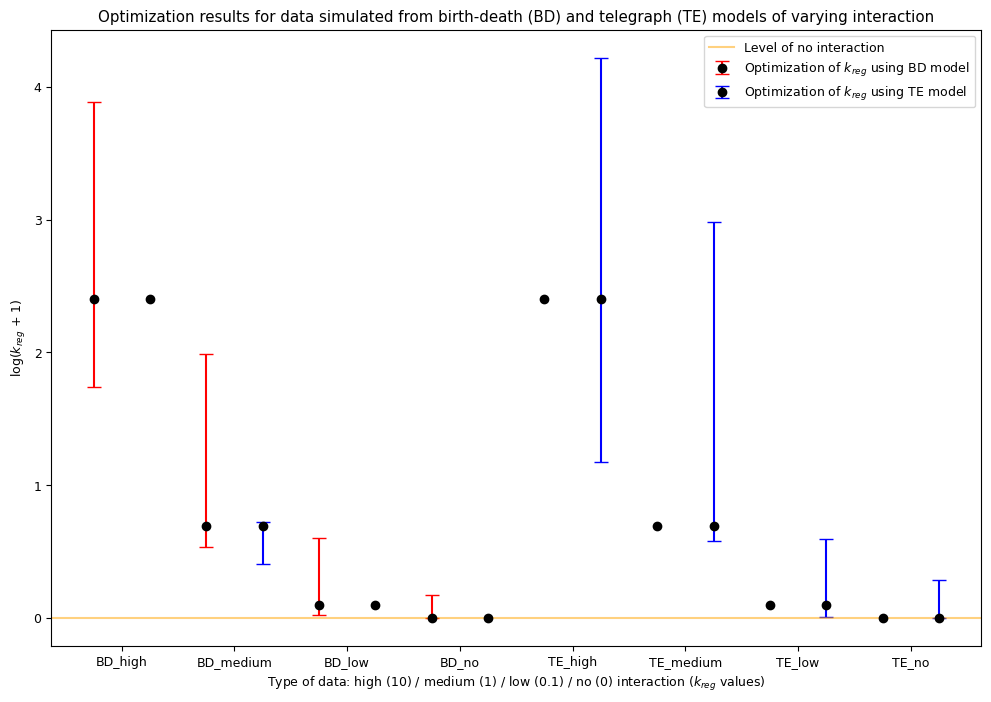

In [114]:
c = 1

def tf(x):
    return np.log(x + c)

ys = np.array([10, 1, 0.1, 0, 10, 1, 0.1, 0])
ys = tf(ys)

plt.figure(figsize=(12, 8))
plt.xticks(np.arange(8), names)

BD_m1_xs = np.arange(8) - 0.25

BD_m1_lbs = []
BD_m1_ubs = []

for i, (key, val) in enumerate(BD_m1.items()):
    try:
        dl = abs(tf(val['k_reg'][0]) - tf(ys[i]))
        du = abs(tf(val['k_reg'][1]) - tf(ys[i]))
    except:
        dl = np.nan
        du = np.nan
    BD_m1_lbs.append(dl)
    BD_m1_ubs.append(du)

BD_m1_ybs = [BD_m1_lbs, BD_m1_ubs]
plt.errorbar(BD_m1_xs, ys, yerr=BD_m1_ybs, fmt='o', color='black', ecolor='red', capsize=5.0, label="Optimization of $k_{reg}$ using BD model")

TE_m1_xs = np.arange(8) + 0.25

TE_m1_lbs = []
TE_m1_ubs = []

for i, (key, val) in enumerate(TE_m1.items()):
    try:
        dl = abs(tf(val['k_reg'][0]) - tf(ys[i]))
        du = abs(tf(val['k_reg'][1]) - tf(ys[i]))
    except:
        dl = np.nan
        du = np.nan
    TE_m1_lbs.append(dl)
    TE_m1_ubs.append(du)


TE_m1_ybs = [TE_m1_lbs, TE_m1_ubs]
plt.errorbar(TE_m1_xs, ys, yerr=TE_m1_ybs, fmt='o', color='black', ecolor='blue', capsize=5.0, label="Optimization of $k_{reg}$ using TE model")

plt.axhline(tf(0), color="orange", alpha=0.5, label="Level of no interaction")

plt.ylabel("log($k_{reg}$ + " + f"{c}" + ")")
plt.title("Optimization results for data simulated from birth-death (BD) and telegraph (TE) models of varying interaction")
plt.xlabel("Type of data: high (10) / medium (1) / low (0.1) / no (0) interaction ($k_{reg}$ values)")
plt.legend()
plt.show()

For the non-poisson TE data we see that the BD optimization performs poorly, as expected, giving an infeasible result (useful, as this indicates the data does not fit the model).

However, for the high transcription BD data the TE optimization terminates after a 5 minute time limit with no solution! (despite TE model being a more general form of BD model). This is annoying as we cannot draw any conclusions and suggests the BD optimization should be prioritised for efficiency.

This suggests a potential pipeline:

Run birth-death method 1, separate into 3 cases:

- non-zero lower bound on $k_{reg}$: suggests interaction present
- zero lower bound on $k_{reg}$: inconclusive result
- infeasible: suggests data does not fit the model

Run telegraph method 1 on 3rd case, produces 3 cases again

In [121]:
# remove models (non-serializable)
for dic in [BD_m1, BD_m2, TE_m1, TE_m2]:
    for key in dic.keys():
        dic[key]['model'] = None

In [123]:
# store
import json
#json.dump( BD_m1, open( "BD_m1_alt.json", 'w' ) )
#json.dump( BD_m2, open( "BD_m2_alt.json", 'w' ) )
#json.dump( TE_m1, open( "TE_m1_alt.json", 'w' ) )
#json.dump( TE_m2, open( "TE_m2_alt.json", 'w' ) )

# Interaction strength vs Confidence level

So far we have used (simulated) data to compute 95% confidence intervals which are then used in optimization to detect interaction. Using thse bounds allows us to detect high / medium and sometimes low strength interaction (~1 to ~0.1 minimum).

We want to know how this 'threshold' of minimum interaction stength that can identified varies with the confidence level of bounds used. To investigate we fix a set of parameters and simulate many samples, varying the interaction parameter value (strength) and confidence level of bootstrapped bounds (level).

This will give a 'p-value' for each interaction strength, the minimum confidence level needed to detect it, OR for each confidence level, a minimum interaction strength that can be detected.


## Initial tests

In [185]:
# birth-death simulation parameters for range of interaction strengths
interaction_strengths = [10, 5, 2, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0]
confidence_levels = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

data = {}

for int_str in interaction_strengths:

    # simulation parameters
    params_simul = {
        'k_tx_1': 1,
        'k_tx_2': 1,
        'k_deg_1': 1,
        'k_deg_2': 1,
        'k_reg': int_str
    }

    # simulate data with chosen interaction strength 
    sample = simulation_BD(params_simul, 5000, 100, 10, plot=False, initial_state=(0, 0))

    # setup dict to store
    data[int_str] = {}

    for con_lvl in confidence_levels:

        # compute bootstrap CI's from sample with given confidence level
        bounds = bootstrap(params_simul, 5000, 5000, mtype=sample, alpha=con_lvl, thresh=10, plot=False)

        # store bounds
        data[int_str][con_lvl] = {
            'bounds': bounds
        }

In [186]:
# optimization parameters
params_optim = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "vo"
}

In [187]:
# optimize all data using BD method 1

# progress indicator
i = 1
tot = len(interaction_strengths) * len(confidence_levels)

for int_str in interaction_strengths:
    for con_lvl in confidence_levels:

        # extract bounds
        bound = data[int_str][con_lvl]['bounds']

        # heuristic: use 1 less than available CI bounds for each transcript
        M = bound['joint'].shape[1] - 1
        N = bound['joint'].shape[2] - 1

        # optimize
        print(f"{i} / {tot} \n")
        solution = optimization_BD(params_optim, bound, M=M, N=N, K=20, silent=True)
        print("\n")

        # store solution
        data[int_str][con_lvl]['solution'] = solution

        # record if interaction detected
        try:
            if solution['k_reg'][0] > 0:
                data[int_str][con_lvl]['interaction_found'] = True
            else:
                data[int_str][con_lvl]['interaction_found'] = False
        # store if infeasible
        except TypeError:
            data[int_str][con_lvl]['interaction_found'] = None

        # increment counter
        i += 1

1 / 306 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (2.945064950466756, 20.0)


2 / 306 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (3.2793963976984957, 20.0)


3 / 306 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (3.650199546009464, 20.0)


4 / 306 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (3.8264254808415945, 20.0)


5 / 306 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (3.934162440754041, 20.0)


6 / 306 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (4.151890014077617, 20.0)


7 / 306 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 

In [188]:
# construct result matrix
result_matrix = np.empty((len(interaction_strengths), len(confidence_levels)))

for i, int_str in enumerate(interaction_strengths):
    for j, con_lvl in enumerate(confidence_levels):

        result_matrix[i, j] = data[int_str][con_lvl]['interaction_found'] 

In [189]:
# display as a table
def _color_red_or_green(val):
    if val == 1.0:
        color = 'green'
    elif val == 0.0:
        color = 'red'
    else:
        color = 'blue'
    return 'color: %s' % color

confidence_percentage = [100 * (1 - alpha) for alpha in confidence_levels]

result_table = pd.DataFrame(data=result_matrix, index=interaction_strengths, columns=confidence_percentage)
result_table.index.name = 'interaction_strength'
display_table = result_table.style.set_caption('confidence_levels').map(_color_red_or_green)
display_table

,99.000000,98.000000,97.000000,96.000000,95.000000,94.000000,93.000000,92.000000,91.000000,90.000000,85.000000,80.000000,75.000000,70.000000,65.000000,60.000000,55.000000,50.000000
interaction_strength,,,,,,,,,,,,,,,,,,
10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,nan,nan,nan
5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,nan,nan
1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,nan
0.900000,1.000000,1.000000,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,nan,nan,nan
0.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,nan
0.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,nan,nan,nan,nan,nan,nan
0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,nan,nan,nan


,99.000000,98.000000,97.000000,96.000000,95.000000,94.000000,93.000000,92.000000,91.000000,90.000000,85.000000,80.000000,75.000000,70.000000,65.000000,60.000000,55.000000,50.000000
interaction_strength,,,,,,,,,,,,,,,,,,
10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,nan,nan
5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan
2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,1.000000,nan
1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,nan,1.000000,nan,nan,nan
0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,nan,nan
0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,nan,nan,nan,1.000000
0.700000,1.000000,nan,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,1.000000,1.000000,nan,1.000000,nan,nan,nan,nan,nan
0.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,nan,nan,nan,nan,1.000000,nan
0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,nan,nan,nan,nan,nan,nan


However, with only a single trial (data simulation, bootstrap and optimization) per strength-confidence pair, results are very variable.

## Multiple runs

To obtain more reliable results that can be used to make conclusions we will run 10 trials (simulation, bootstrap and optimization) per strength-confidence pair and display the proportion of times interaction is detected, or proportion of times the optimization is feasible:

In [203]:
# birth-death simulation parameters for range of interaction strengths
interaction_strengths = [10, 5, 2, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0]
confidence_levels = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# optimization parameters
params_optim = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "vo"
}

# number of runs
runs = 10

# store all data
data_list = []

# run test 10 times
for run in range(runs):

    print(f"Run {run} \n")

    data = {}

    # progress indicator
    j = 1
    tot_j = len(interaction_strengths)

    for int_str in interaction_strengths:

        # simulation parameters
        params_simul = {
            'k_tx_1': 1,
            'k_tx_2': 1,
            'k_deg_1': 1,
            'k_deg_2': 1,
            'k_reg': int_str
        }

        print(f"Sample {j} / {tot_j} \n")

        # simulate data with chosen interaction strength 
        sample = simulation_BD(params_simul, 5000, 100, 10, plot=False, initial_state=(0, 0))

        # increment counter
        j += 1

        # setup dict to store
        data[int_str] = {}

        for con_lvl in confidence_levels:

            # compute bootstrap CI's from sample with given confidence level
            bounds = bootstrap(params_simul, 5000, 5000, mtype=sample, alpha=con_lvl, thresh=10, plot=False)

            # store bounds
            data[int_str][con_lvl] = {
                'bounds': bounds
            }

    # progress indicator
    i = 1
    tot_i = len(interaction_strengths) * len(confidence_levels)

    # optimize all data using BD method 1
    for int_str in interaction_strengths:
        for con_lvl in confidence_levels:

            # extract bounds
            bound = data[int_str][con_lvl]['bounds']

            # heuristic: use 1 less than available CI bounds for each transcript
            M = bound['joint'].shape[1] - 1
            N = bound['joint'].shape[2] - 1

            # optimize
            print(f"Optim {i} / {tot_i} \n")
            solution = optimization_BD(params_optim, bound, M=M, N=N, K=20, silent=True)
            print("\n")

            # store solution
            data[int_str][con_lvl]['solution'] = solution

            # increment counter
            i += 1

    # store data
    data_list.append(data)

Run 0 

Sample 1 / 17 

Sample 2 / 17 

Sample 3 / 17 

Sample 4 / 17 

Sample 5 / 17 

Sample 6 / 17 

Sample 7 / 17 

Sample 8 / 17 

Sample 9 / 17 

Sample 10 / 17 

Sample 11 / 17 

Sample 12 / 17 

Sample 13 / 17 

Sample 14 / 17 

Sample 15 / 17 

Sample 16 / 17 

Sample 17 / 17 

Optim 1 / 306 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (3.395287349698576, 20.0)


Optim 2 / 306 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (3.6861319795824317, 20.0)


Optim 3 / 306 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (3.7653045820716016, 20.0)


Optim 4 / 306 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (3.956946425471144, 20.0)


Optim 5 / 306 

k_tx_1 variable, not optimized
k_tx_2 variable, not optimi

In [204]:
# construct result array
result_matrix = np.zeros((len(interaction_strengths), len(confidence_levels)))

# loop over all results
for run in range(runs):
    for i, int_str in enumerate(interaction_strengths):
        for j, con_lvl in enumerate(confidence_levels):

            try:
                # lower bound non-zero: interaction detected
                if data_list[run][int_str][con_lvl]['solution']['k_reg'][0] > 0:

                    # add to count
                    result_matrix[i, j] += (1 / runs)

            except TypeError:
                # infeasible
                continue

### Interaction detection rate plot

In [207]:
def _color_red_or_green(val):
    if val >= 0.75:
        color = 'green'
    elif val >= 0.25:
        color = 'orange'
    elif val >= 0.0:
        color = 'red'
    else:
        color = 'blue'
    return 'color: %s' % color

confidence_percentage = [100 * (1 - alpha) for alpha in confidence_levels]

result_table = pd.DataFrame(data=result_matrix, index=interaction_strengths, columns=confidence_percentage)
result_table.index.name = 'interaction_strength'
display_table = result_table.style.set_caption('confidence_levels').map(_color_red_or_green)
display_table

,99.000000,98.000000,97.000000,96.000000,95.000000,94.000000,93.000000,92.000000,91.000000,90.000000,85.000000,80.000000,75.000000,70.000000,65.000000,60.000000,55.000000,50.000000
interaction_strength,,,,,,,,,,,,,,,,,,
10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.900000,0.800000,0.800000,0.600000,0.600000,0.600000,0.500000,0.400000
5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.900000,0.800000,0.800000,0.700000,0.500000,0.400000,0.300000,0.300000
2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.800000,0.700000,0.700000,0.700000,0.500000,0.300000,0.100000
1.000000,1.000000,1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.800000,0.800000,0.700000,0.700000,0.600000,0.400000,0.400000,0.400000,0.300000,0.200000
0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.900000,0.800000,0.700000,0.400000,0.200000,0.100000,0.100000,0.100000,0.000000
0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.900000,0.900000,0.900000,0.800000,0.700000,0.600000,0.500000,0.400000,0.300000,0.200000,0.000000,0.000000
0.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,0.700000,0.600000,0.300000,0.300000,0.300000,0.300000,0.200000
0.600000,0.800000,0.800000,0.800000,0.900000,0.900000,0.900000,1.000000,1.000000,1.000000,1.000000,0.900000,0.700000,0.700000,0.600000,0.300000,0.300000,0.200000,0.200000
0.500000,0.800000,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,0.700000,0.500000,0.400000,0.300000,0.300000,0.300000,0.300000


In [213]:
# construct result array
infeasibility_matrix = np.zeros((len(interaction_strengths), len(confidence_levels)))

# loop over all results
for run in range(runs):
    for i, int_str in enumerate(interaction_strengths):
        for j, con_lvl in enumerate(confidence_levels):

            # infeasible
            if data_list[run][int_str][con_lvl]['solution']['k_reg'][0] == None:

                # add to count
                infeasibility_matrix[i, j] += (1 / runs)

### Infeasibility rate plot

In [215]:
def _color_red_or_green(val):
    if val >= 0.75:
        color = 'red'
    elif val >= 0.25:
        color = 'orange'
    elif val >= 0.0:
        color = 'green'
    else:
        color = 'blue'
    return 'color: %s' % color

confidence_percentage = [100 * (1 - alpha) for alpha in confidence_levels]

infeasible_table = pd.DataFrame(data=infeasibility_matrix, index=interaction_strengths, columns=confidence_percentage)
infeasible_table.index.name = 'interaction_strength'
display_infeasible_table = infeasible_table.style.set_caption('confidence_levels').map(_color_red_or_green)
display_infeasible_table

,99.000000,98.000000,97.000000,96.000000,95.000000,94.000000,93.000000,92.000000,91.000000,90.000000,85.000000,80.000000,75.000000,70.000000,65.000000,60.000000,55.000000,50.000000
interaction_strength,,,,,,,,,,,,,,,,,,
10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.200000,0.200000,0.400000,0.400000,0.400000,0.500000,0.600000
5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.200000,0.200000,0.300000,0.500000,0.600000,0.700000,0.700000
2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.200000,0.300000,0.300000,0.300000,0.500000,0.700000,0.900000
1.000000,0.000000,0.000000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.200000,0.200000,0.300000,0.300000,0.400000,0.600000,0.600000,0.600000,0.700000,0.800000
0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.200000,0.300000,0.600000,0.800000,0.900000,0.900000,0.900000,1.000000
0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,1.000000,1.000000
0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.400000,0.700000,0.700000,0.700000,0.700000,0.800000
0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.300000,0.300000,0.400000,0.700000,0.700000,0.800000,0.800000
0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.500000,0.600000,0.700000,0.700000,0.700000,0.700000
